# Experiments with embeddings - changing subset of abstracts for training based on age of publication of articles

- This experiments shows if it is helping for predictions of citations to train embeddings with all old abstracts or if will help to use just the new one. 

TODO: add to graph how dataset for traning embeddings is reduced ( how many articles) 

### Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import functions    # my own functions which are used in more notebooks
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
from sklearn.metrics import auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gensim
print((gensim.__version__))  

4.1.2


## Upload cleaned abstracts

In [3]:
df_all = pd.read_csv("1.Preprocessing_outputs/df_sw_tok_low_punc_lemm_v6.csv").rename(columns = {'doi_x':'doi'}).set_index("doi")

## Parameters - years of citations 

In [283]:
train_year = 2019
test_year = 2020

# Add target flag for dataframe with dois

In [284]:
train_df = functions.add_target_opencitatins_marginal(target_year = train_year,df = df_all,target_col_name = "target")
train_df = train_df[(df_all['Year']<=train_year) & (df_all['Year']>=train_year-1)] # filter articles for training published to train year
print(len(train_df))

test_df = functions.add_target_opencitatins_marginal(target_year = test_year, df = df_all,target_col_name = "target")
test_df = test_df[test_df["Year"]==test_year] # filter articles published during test year
print(len(test_df))

C:\Users\berl03\AppData\Local\Temp/ipykernel_8044/1290460241.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_df = functions.add_target_opencitatins_marginal(target_year = train_year,df = df_all,target_col_name = "target")
b'Skipping line 171761: expected 5 fields, saw 8\nSkipping line 208878: expected 5 fields, saw 8\n'


0    9202
1    7445
Name: target, dtype: int64
16647
2820


C:\Users\berl03\AppData\Local\Temp/ipykernel_8044/1290460241.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df = train_df[(df_all['Year']<=train_year) & (df_all['Year']>=train_year-1)] # filter articles for training published to train year
C:\Users\berl03\AppData\Local\Temp/ipykernel_8044/1290460241.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_df = functions.add_target_opencitatins_marginal(target_year = test_year, df = df_all,target_col_name = "target")
b'Skipping line 171761: expected 5 fields, saw 8\nSkipping line 208878: expected 5 fields, saw 8\n'


0    22366
1    17799
Name: target, dtype: int64
40165
20682


# EMBEDDINGS

## Agregating w2v Embeddings + LR

- w2v was trained on all articles from kaggle (with or without target - openctitations) - to the target year of publication

In [285]:
list_df = []
diff_list = [1,2,3,4,5,6,7,8,9,10,20,30,40,50]
for diff in diff_list:
    
    print("Between_"+str(train_year-diff) +" and "+str(train_year))
    
    model_w2v = gensim.models.Word2Vec.load("2.Train_embeddings_outpus/w2v_published_between_"+str(train_year-diff) + " and "+ str(train_year)+".model")
    train_df["abstract_tokenized"] = functions.tokenized_column(train_df.reset_index()["abstract_cleaned"])
    df_X_train_avg = functions.transform_to_document_vector(text_col_tokenized = train_df.reset_index().abstract_tokenized,model = model_w2v,index_col_list = list(train_df.index),agg_func = "avg").fillna(0)
    test_df["abstract_tokenized"] = functions.tokenized_column(test_df.reset_index()["abstract_cleaned"])
    df_X_test_avg = functions.transform_to_document_vector(text_col_tokenized = test_df.reset_index().abstract_tokenized,model = model_w2v,index_col_list = list(test_df.index),agg_func = "avg").fillna(0)
    
    X_train_w2v_avg, X_test_w2v_avg, y_train_w2v, y_test_w2v = train_test_split(df_X_train_avg, train_df.target, test_size=0.2, random_state=1,stratify=train_df.target)
    splitted_train_features = y_test_w2v.reset_index().merge(train_df, on="doi",how="left")
    
    cf_w2v_splitted_train_avg = LogisticRegression(random_state=0, C=0.2, penalty = "l1",solver = "liblinear").fit(X_train_w2v_avg, y_train_w2v)  
    y_pred_w2v_splitted_train_avg = cf_w2v_splitted_train_avg.predict_proba(X_test_w2v_avg)[:,1]
    y_pred_w2v_whole_train_avg = cf_w2v_splitted_train_avg.predict_proba(df_X_train_avg)[:,1]
    y_pred_w2v_test_avg = cf_w2v_splitted_train_avg.predict_proba(df_X_test_avg)[:,1]

    results_train_w2v_avg = pd.DataFrame(zip(list( y_pred_w2v_whole_train_avg),list(train_df.target), list(train_df.Year), list(train_df.OpenCitations)),columns=["y_pred","real","Year","OpenCitations"])
    results_splitted_train_w2v_avg = pd.DataFrame(zip(list( y_pred_w2v_splitted_train_avg),list(y_test_w2v), list(splitted_train_features.Year), list(splitted_train_features.OpenCitations)),columns=["y_pred","real","Year","OpenCitations"])
    results_test_w2v_avg = pd.DataFrame(zip(list( y_pred_w2v_test_avg),list(test_df.target), list(test_df.Year), list(test_df.OpenCitations)),columns=["y_pred","real","Year","OpenCitations"])

    matrix_pred_real_w2v = [ 
             ('predictions whole train set', y_pred_w2v_whole_train_avg, train_df.target),
             ('predictions splitted train set', y_pred_w2v_splitted_train_avg,y_test_w2v),
             ('predictions tested new month',y_pred_w2v_test_avg,test_df.target)
                            ]
    list_auc=[]
    list_years = []
    list_name=[]
    for name, pred, real in matrix_pred_real_w2v: 
        list_name.append(name)
        list_auc.append(roc_auc_score(real,pred))
        list_years.append("Between_"+str(train_year-diff) +" and "+str(train_year))
    
    auc_list_top = []
    for results in [results_train_w2v_avg,results_splitted_train_w2v_avg, results_test_w2v_avg]:
        auc_list_top.append(roc_auc_score(functions.x_first_last_val(results,0.05).real.values, 
                                          functions.x_first_last_val(results,0.05).y_pred.values))
    
    list_df.append(pd.DataFrame(zip(list_auc,list_name,auc_list_top,list_years),columns=["auc_all","name","auc_top_5_perc","years"]))
           

Between_2018 and 2019


100%|████████████████████████████████████████████████████████████████████████████| 20682/20682 [03:39<00:00, 94.13it/s]


Between_2017 and 2019


100%|████████████████████████████████████████████████████████████████████████████| 20682/20682 [03:59<00:00, 86.42it/s]


Between_2016 and 2019


100%|████████████████████████████████████████████████████████████████████████████| 20682/20682 [04:20<00:00, 79.42it/s]


Between_2015 and 2019


100%|████████████████████████████████████████████████████████████████████████████| 20682/20682 [04:20<00:00, 79.35it/s]


Between_2014 and 2019


100%|████████████████████████████████████████████████████████████████████████████| 20682/20682 [04:33<00:00, 75.57it/s]


Between_2013 and 2019


100%|████████████████████████████████████████████████████████████████████████████| 20682/20682 [04:42<00:00, 73.12it/s]


Between_2012 and 2019


100%|████████████████████████████████████████████████████████████████████████████| 20682/20682 [04:34<00:00, 75.27it/s]


Between_2011 and 2019


100%|████████████████████████████████████████████████████████████████████████████| 20682/20682 [04:48<00:00, 71.79it/s]


Between_2010 and 2019


100%|████████████████████████████████████████████████████████████████████████████| 20682/20682 [04:53<00:00, 70.44it/s]


Between_2009 and 2019


100%|████████████████████████████████████████████████████████████████████████████| 20682/20682 [04:48<00:00, 71.63it/s]


Between_1999 and 2019


100%|████████████████████████████████████████████████████████████████████████████| 20682/20682 [04:55<00:00, 70.03it/s]


Between_1989 and 2019


100%|████████████████████████████████████████████████████████████████████████████| 20682/20682 [05:01<00:00, 68.60it/s]


Between_1979 and 2019


100%|████████████████████████████████████████████████████████████████████████████| 20682/20682 [04:58<00:00, 69.35it/s]


Between_1969 and 2019


100%|████████████████████████████████████████████████████████████████████████████| 20682/20682 [04:58<00:00, 69.31it/s]


In [286]:
df = pd.concat(list_df)
df

,auc_all,name,auc_top_5_perc,years
0,0.614860,predictions whole train set,0.695740,Between_2018 and 2019
1,0.581801,predictions splitted train set,0.668367,Between_2018 and 2019
2,0.502691,predictions tested new month,0.491285,Between_2018 and 2019
0,0.608244,predictions whole train set,0.695086,Between_2017 and 2019
1,0.586741,predictions splitted train set,0.735969,Between_2017 and 2019
2,0.509019,predictions tested new month,0.509779,Between_2017 and 2019
0,0.616994,predictions whole train set,0.686988,Between_2016 and 2019
1,0.580277,predictions splitted train set,0.724490,Between_2016 and 2019
2,0.522199,predictions tested new month,0.546153,Between_2016 and 2019
0,0.614286,predictions whole train set,0.766913,Between_2015 and 2019


In [287]:
df_piv = df.pivot(index=["years"], columns = ["name"],values=["auc_all","auc_top_5_perc"])
df_piv

auc_all  \
name                  predictions splitted train set   
years                                                  
Between_1969 and 2019                       0.583706   
Between_1979 and 2019                       0.602311   
Between_1989 and 2019                       0.594679   
Between_1999 and 2019                       0.582004   
Between_2009 and 2019                       0.596977   
Between_2010 and 2019                       0.586906   
Between_2011 and 2019                       0.590488   
Between_2012 and 2019                       0.581356   
Between_2013 and 2019                       0.594679   
Between_2014 and 2019                       0.589446   
Between_2015 and 2019                       0.598984   
Between_2016 and 2019                       0.580277   
Between_2017 and 2019                       0.586741   
Between_2018 and 2019                       0.581801   

                                                    \
name                  predictions tested new month   
years                                                
Between_1969 and 2019                     0.507263   
Between_1979 and 2019                     0.502251   
Between_1989 and 2019                     0.521970   
Between_1999 and 2019                     0.489337   
Between_2009 and 2019                     0.499315   
Between_2010 and 2019                     0.497681   
Between_2011 and 2019                     0.509697   
Between_2012 and 2019                     0.499326   
Between_2013 and 2019                     0.512567   
Between_2014 and 2019                     0.510116   
Between_2015 and 2019                     0.509445   
Between_2016 and 2019                     0.522199   
Between_2017 and 2019                     0.509019   
Between_2018 and 2019                     0.502691   

                                                   \
name                  predictions whole train set   
years                                               
Between_1969 and 2019                    0.608392   
Between_1979 and 2019                    0.616681   
Between_1989 and 2019                    0.615688   
Between_1999 and 2019                    0.609934   
Between_2009 and 2019                    0.611572   
Between_2010 and 2019                    0.610978   
Between_2011 and 2019                    0.611982   
Between_2012 and 2019                    0.614778   
Between_2013 and 2019                    0.613014   
Between_2014 and 2019                    0.613150   
Between_2015 and 2019                    0.614286   
Between_2016 and 2019                    0.616994   
Between_2017 and 2019                    0.608244   
Between_2018 and 2019                    0.614860   

                                      auc_top_5_perc  \
name                  predictions splitted train set   
years                                                  
Between_1969 and 2019                       0.735969   
Between_1979 and 2019                       0.776786   
Between_1989 and 2019                       0.846939   
Between_1999 and 2019                       0.785714   
Between_2009 and 2019                       0.724490   
Between_2010 and 2019                       0.750000   
Between_2011 and 2019                       0.848214   
Between_2012 and 2019                       0.775510   
Between_2013 and 2019                       0.774235   
Between_2014 and 2019                       0.701531   
Between_2015 and 2019                       0.674745   
Between_2016 and 2019                       0.724490   
Between_2017 and 2019                       0.735969   
Between_2018 and 2019                       0.668367   

                                                                                
name                  predictions tested new month predictions whole train set  
years                                                                           
Between_1969 and 2019                     0.493717                    0.704

<AxesSubplot:xlabel='years'>

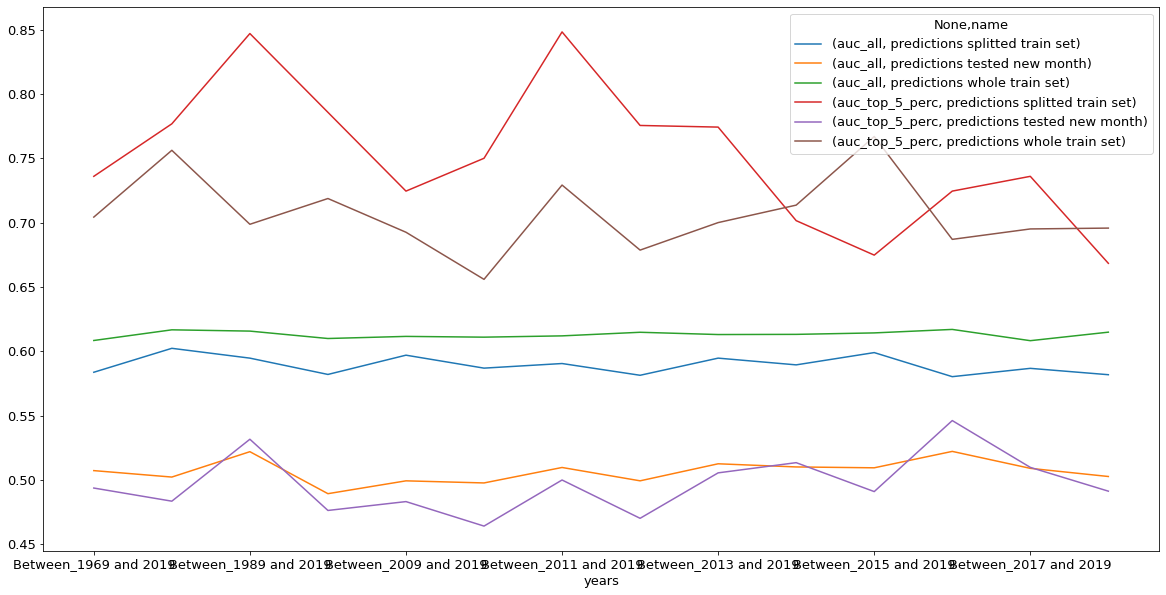

In [288]:
df_piv.plot(figsize=(20,10))

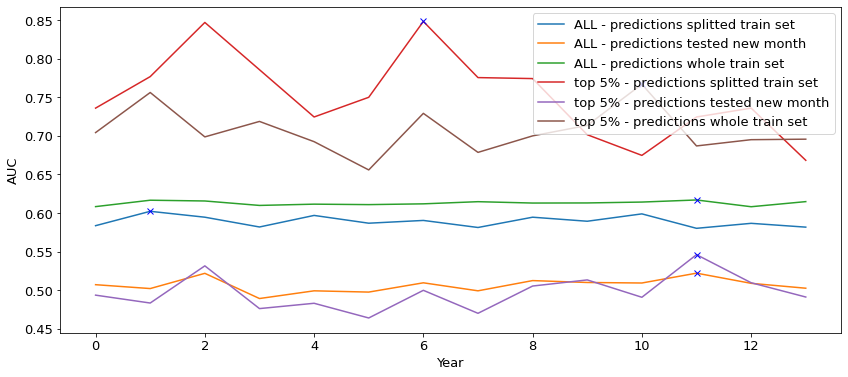

In [289]:
fig = plt.figure(figsize=(14,6))
plt.rcParams.update({'font.size': 13})

ax = plt.axes()
y = df_piv[df_piv.columns[0]].values
y_max = np.argmax(y, axis=0)
plt.plot(y,label="ALL - predictions splitted train set")
plt.plot(y_max,y[y_max],'xb-')

y = df_piv[df_piv.columns[1]].values
y_max = np.argmax(y, axis=0)
plt.plot(y,label="ALL - predictions tested new month")
plt.plot(y_max,y[y_max],'xb-')

y = df_piv[df_piv.columns[2]].values
y_max = np.argmax(y, axis=0)
plt.plot(y,label="ALL - predictions whole train set")
plt.plot(y_max,y[y_max],'xb-')

y = df_piv[df_piv.columns[3]].values
y_max = np.argmax(y, axis=0)
plt.plot(y,label="top 5% - predictions splitted train set")
plt.plot(y_max,y[y_max],'xb-')

y = df_piv[df_piv.columns[4]].values
y_max = np.argmax(y, axis=0)
plt.plot(y,label="top 5% - predictions tested new month")
plt.plot(y_max,y[y_max],'xb-')


y = df_piv[df_piv.columns[5]].values
y_max = np.argmax(y, axis=0)
plt.plot(y,label = "top 5% - predictions whole train set")
plt.plot(y_max,y[y_max],'xb-')


plt.xlabel('Year',fontsize=13)
plt.ylabel('AUC',fontsize=13)
plt.legend(loc="upper right",fontsize=13)

plt.show()